In [36]:
import numpy as np
from matplotlib import pyplot
from IPython.display import display, clear_output

In [2]:
class BernoulliBandit:
    def __init__ (self, means, randomstate = None):
        self.means = means
        self.random = np.random.RandomState(randomstate)
        self.k_star = np.argmax(means)
        self.gaps = means[self.k_star] - means
        self.regret = []
        
    def get_K(self):
        return len(self.means)
    
    def play(self, action):
        self.regret.append(self.gaps[action])
        sample = self.random.rand(self.get_K())
        reward = int(sample[action] < self.means[action])
        return reward
            
    def get_cumulative_regret(self):
        return np.cumsum(self.regret)

In [3]:
def greedy(bandit, T):
    estimates = []
    for k in range(bandit.get_K()):
        estimates.append(bandit.play(k))
    k_t = np.argmax(estimates)
    for t in range(bandit.get_K(), T):
        r_t = bandit.play(k_t)
    return k_t

In [5]:
def etc(bandit, T, m):
    estimates = []
    for k in range(bandit.get_K()):
        m_estimates = []
        for i in range(m):
            m_estimates.append(bandit.play(k))
        estimates.append(np.mean(m_estimates))

    k_t = np.argmax(estimates)
    for t in range(m * bandit.get_K(), T):
        r_t = bandit.play(k_t)
    return k_t

In [73]:
def etc_experience(N, T, m, means):
    mistakes = 0
    pseudo_regrets = []
    
    for n in range(N):
        bandit = BernoulliBandit(means)
        k_t = etc(bandit, T, m)
        mistakes += (k_t != bandit.k_star)
        pseudo_regrets.append(bandit.get_cumulative_regret())

    avg_cumul_regret = np.mean(pseudo_regrets, axis=0)
    std_cumul_regret = np.std(pseudo_regrets, axis=0)
    
    return  (mistakes / N, avg_cumul_regret, std_cumul_regret)

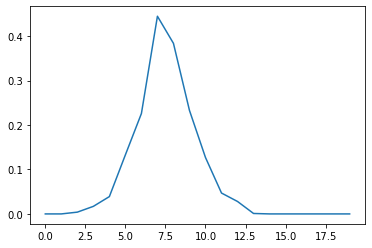

In [74]:
N = 1000
T = 200
m = 10

means = np.array([0.1, 0.9])
step = 0.05

cumul_mistakes = []

fig = pyplot.figure()
ax = fig.add_subplot(1, 1, 1) 

for i in range(15):
    (mistakes_mean, _, _) = etc_experience(N, T, m, means)
    means[0] += step
    means[1] -= step
    cumul_mistakes.append(mistakes_mean)
    
    x = np.arange(i + 1)
    ax.set_xlim(0, i)
    ax.cla()
    ax.plot(x, cumul_mistakes)
    display(fig)
    clear_output(wait = True)
    pyplot.pause(0.4)

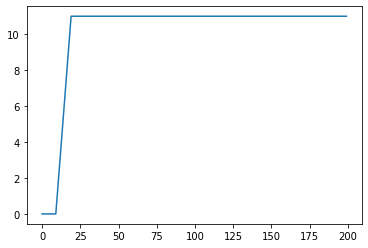

In [77]:
N = 1000
T = 200
m = 10

means = np.array([0.1, 0.9])
step = 0.05

fig = pyplot.figure()
ax = fig.add_subplot(1, 1, 1) 

for i in range(15):
    (_, avg_cumul_regret, std_cumul_regret) = etc_experience(N, T, m, means)
    means[0] += step
    means[1] -= step
    cumul_mistakes.append(mistakes_mean)
    
    x = np.arange(len(avg_cumul_regret))
    ax.cla()
    ax.plot(x, avg_cumul_regret)
    ax.fill_between(x, avg_cumul_regret, avg_cumul_regret + std_cumul_regret, alpha=0.4)
    display(fig)
    clear_output(wait = True)
    pyplot.pause(0.4)